# Entity graph rag

In [ ]:
from __future__ import annotations

import math
import pickle
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple

import networkx as nx


def node_id(ntype: str, value: str) -> str:
    return f"{ntype}:{value}"


def base_rtype(rtype: str) -> str:
    return rtype[:-4] if rtype.endswith("_rev") else rtype


def default_relation_importance() -> Dict[str, float]:
    return {
        "country_has_policy": 0.95,
        "policy_targets_country": 0.95,
        "resolver_in_org": 0.85,
        "answer_ip_in_org": 0.85,
        "resolver_in_asn": 0.55,
        "answer_ip_in_asn": 0.55,
        "domain_category": 0.55,
        "domain_in_country": 0.35,
        "resolver_in_country": 0.30,
        "answer_ip_in_country": 0.30,
    }


def compute_pagerank_centrality(G: nx.MultiDiGraph, alpha: float = 0.85, max_iter: int = 100) -> Dict[str, float]:
    # MultiDiGraph -> DiGraph
    H = nx.DiGraph()
    H.add_nodes_from(G.nodes(data=True))
    for u, v, _, _ in G.edges(keys=True, data=True):
        if H.has_edge(u, v):
            H[u][v]["weight"] += 1.0
        else:
            H.add_edge(u, v, weight=1.0)
    return nx.pagerank(H, alpha=alpha, max_iter=max_iter, weight="weight")


@dataclass
class Path:
    nodes: List[str]
    edges: List[str]
    sum_score: float

    def re_score(self) -> float:
        L = len(self.edges)
        return 0.0 if L == 0 else self.sum_score / math.sqrt(L)


class EntityPathRetriever:
    def __init__(
        self,
        G: nx.MultiDiGraph,
        centrality: Optional[Dict[str, float]] = None,
        relation_importance: Optional[Dict[str, float]] = None,
        decay_alpha: float = 0.6,
        max_expand_edges: int = 5,
        avoid_cycles: bool = True,
        per_neighbor_keep: int = 2,
    ):
        self.G = G
        self.I = relation_importance or default_relation_importance()
        self.C = centrality or compute_pagerank_centrality(G)
        self.decay_alpha = decay_alpha
        self.max_expand_edges = max_expand_edges
        self.avoid_cycles = avoid_cycles
        self.per_neighbor_keep = per_neighbor_keep

    def _I(self, rtype: str) -> float:
        return float(self.I.get(base_rtype(rtype), 0.3))

    def _C(self, v: str) -> float:
        return float(self.C.get(v, 1e-6))

    def _beta(self, hop_i: int) -> float:
        return math.exp(-self.decay_alpha * (hop_i - 1))

    def _top_expansions(
        self,
        u: str,
        visited: Optional[set],
        target: Optional[str],
    ) -> List[Tuple[str, str, float]]:
        if u not in self.G:
            return []

        candidates: List[Tuple[str, str, float]] = []
        forced: Optional[Tuple[str, str, float]] = None

        for _, v, k, data in self.G.out_edges(u, keys=True, data=True):
            if self.avoid_cycles and visited is not None and v in visited:
                continue
            rtype = str(data.get("rtype", "unknown"))
            score = self._I(rtype) * self._C(v)
            candidates.append((v, rtype, score))

            if target is not None and v == target and forced is None:
                forced = (v, rtype, score)

        if not candidates:
            return []

        by_v: Dict[str, List[Tuple[str, str, float]]] = {}
        for v, rtype, score in candidates:
            by_v.setdefault(v, []).append((v, rtype, score))

        compressed: List[Tuple[str, str, float]] = []
        for v, arr in by_v.items():
            arr.sort(key=lambda x: x[2], reverse=True)
            compressed.extend(arr[: self.per_neighbor_keep])

        compressed.sort(key=lambda x: x[2], reverse=True)
        out = compressed[: self.max_expand_edges]

        if forced is not None:
            key_forced = (forced[0], forced[1])
            if all((v, r) != key_forced for v, r, _ in out):

                if len(out) < self.max_expand_edges:
                    out.append(forced)
                else:
                    out[-1] = forced
        return out

    def beam_search_paths(
        self,
        start: str,
        target: str,
        max_depth: int = 5,
        beam_width: int = 20,
        top_k: int = 5,
    ) -> List[Path]:
        if start not in self.G or target not in self.G:
            return []

        frontier: List[Path] = [Path(nodes=[start], edges=[], sum_score=0.0)]
        completed: List[Path] = []

        for _depth in range(1, max_depth + 1):
            nxt: List[Path] = []

            for p in frontier:
                u = p.nodes[-1]
                visited = set(p.nodes) if self.avoid_cycles else None

                for v, rtype, _ in self._top_expansions(u, visited, target):
                    hop_i = len(p.edges) + 1
                    contrib = self._beta(hop_i) * self._I(rtype) * self._C(v)

                    np = Path(
                        nodes=p.nodes + [v],
                        edges=p.edges + [rtype],
                        sum_score=p.sum_score + contrib,
                    )
                    (completed if v == target else nxt).append(np)

            if not nxt:
                break

            nxt.sort(key=lambda x: x.re_score(), reverse=True)
            frontier = nxt[:beam_width]

        completed.sort(key=lambda x: x.re_score(), reverse=True)
        return completed[:top_k]


def retrieve_entity_paths_for_record(
    retriever: EntityPathRetriever,
    domain: str,
    resolver_ip: str,
    answer_ip: str,
    max_depth: int = 5,
    beam_width: int = 20,
    top_k_each_pair: int = 3,
) -> List[Dict[str, Any]]:
    D = node_id("D", domain.lower())
    R = node_id("R", resolver_ip.strip())
    A = node_id("A", answer_ip.strip())

    pairs = [("R->D", R, D), ("D->A", D, A), ("R->A", R, A)]
    out: List[Dict[str, Any]] = []

    for tag, s, t in pairs:
        for p in retriever.beam_search_paths(s, t, max_depth=max_depth, beam_width=beam_width, top_k=top_k_each_pair):
            out.append({"pair": tag, "score": p.re_score(), "nodes": p.nodes, "edges": p.edges})

    out.sort(key=lambda x: x["score"], reverse=True)
    return out


if __name__ == "__main__":
    with open("../outputs/entity_graph.gpickle", "rb") as f:
        G = pickle.load(f)

    retriever = EntityPathRetriever(
        G,
        decay_alpha=0.6,
        max_expand_edges=5,
        avoid_cycles=True,
    )

    paths = retrieve_entity_paths_for_record(
        retriever,
        domain="yandex.ru",
        resolver_ip="5.58.102.238",
        answer_ip="185.53.79.83",
        max_depth=5,
        beam_width=20,
        top_k_each_pair=3,
    )

    for i, p in enumerate(paths[:10], 1):
        print(f"[{i}] {p['pair']} score={p['score']:.6f}")
        print("    " + " -> ".join(p["nodes"]))
        print("    edges: " + " | ".join(p["edges"]))


[1] D->A score=0.004955
    D:yandex.ru -> C:ru -> P:Russia–Ukraine splinternet / sovereign DNS policy -> C:ua -> A:185.53.79.83
    edges: domain_in_country | country_has_policy | policy_targets_country | answer_ip_in_country_rev
[2] D->A score=0.004955
    D:yandex.ru -> C:ru -> P:Blocking Russian state-controlled media websites -> C:ua -> A:185.53.79.83
    edges: domain_in_country | policy_targets_country_rev | country_has_policy_rev | answer_ip_in_country_rev
[3] D->A score=0.004955
    D:yandex.ru -> C:ru -> P:Ban on Russian social networks VKontakte and Odnoklassniki -> C:ua -> A:185.53.79.83
    edges: domain_in_country | policy_targets_country_rev | country_has_policy_rev | answer_ip_in_country_rev
[4] R->D score=0.004107
    R:5.58.102.238 -> C:ua -> P:Russia–Ukraine splinternet / sovereign DNS policy -> C:ru -> D:yandex.ru
    edges: resolver_in_country | policy_targets_country_rev | country_has_policy_rev | domain_in_country_rev
[5] R->D score=0.004107
    R:5.58.102.238 ->

# test

## find target node


✅ 目标节点: A:185.53.79.83
属性: {'ntype': 'A', 'value': '185.53.79.83'}

🔹 子图节点数: 4，边数: 13

🔸 边列表：
A:185.53.79.83 → S:16223  |  rtype: answer_ip_in_asn
A:185.53.79.83 → O:Maxnet Telecom, Ltd  |  rtype: answer_ip_in_org
A:185.53.79.83 → C:ua  |  rtype: answer_ip_in_country
S:16223 → A:185.53.79.83  |  rtype: answer_ip_in_asn_rev
O:Maxnet Telecom, Ltd → A:185.53.79.83  |  rtype: answer_ip_in_org_rev
C:ua → A:185.53.79.83  |  rtype: answer_ip_in_country_rev
O:Maxnet Telecom, Ltd → R:5.58.102.238  |  rtype: resolver_in_org_rev
C:ua → D:kasta.ua  |  rtype: domain_in_country_rev
C:ua → D:raiffeisen.ua  |  rtype: domain_in_country_rev
C:ua → D:mof.gov.ua  |  rtype: domain_in_country_rev
C:ua → D:price.ua  |  rtype: domain_in_country_rev
C:ua → D:tavrmedia.ua  |  rtype: domain_in_country_rev
S:16223 → R:5.58.102.238  |  rtype: resolver_in_asn_rev


/tmp/ipykernel_1168587/679729776.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


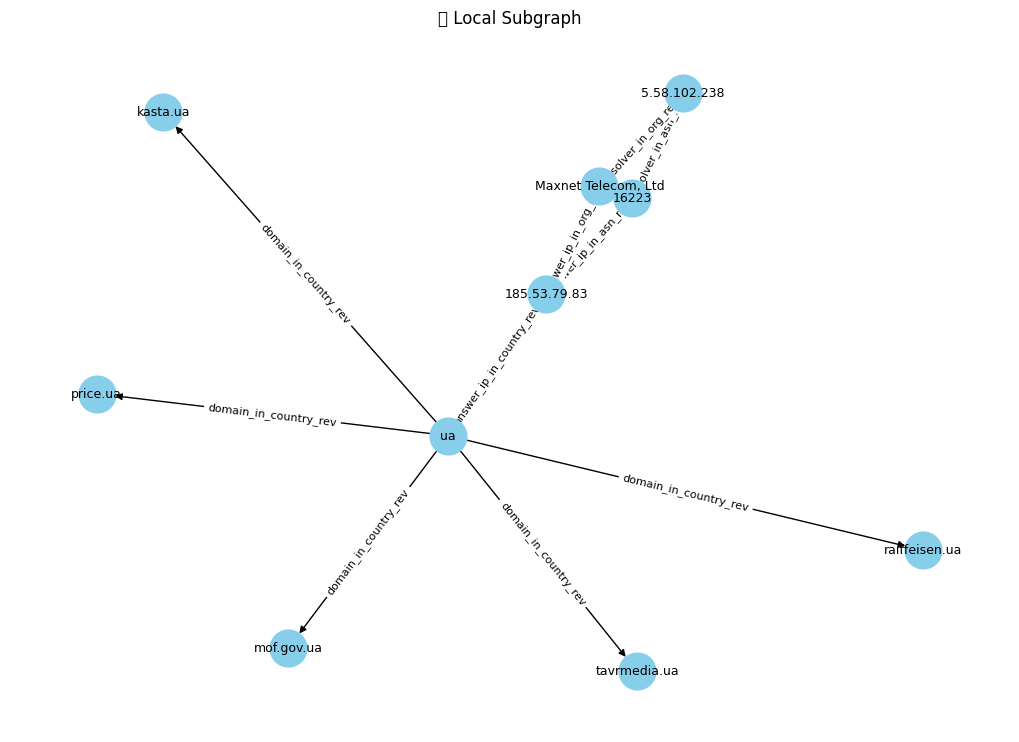

In [ ]:
import pickle
import random
import networkx as nx


with open("../outputs/entity_graph.gpickle", "rb") as f:
    G: nx.MultiDiGraph = pickle.load(f)


target_node = "A:185.53.79.83"

if target_node not in G:
    print(f"❌ 节点不存在: {target_node}")
    exit()

print(f"\n✅ 目标节点: {target_node}")
print(f"属性: {G.nodes[target_node]}")

# ---------- Step 1: Select up to 10 edges related to the target node ----------
edges_1hop = []

# 出边
for v in G.successors(target_node):
    for key in G[target_node][v]:
        edge_data = G[target_node][v][key]
        edges_1hop.append((target_node, v, edge_data))

# 入边
for u in G.predecessors(target_node):
    for key in G[u][target_node]:
        edge_data = G[u][target_node][key]
        edges_1hop.append((u, target_node, edge_data))

# 限制最多 10 条
edges_1hop = edges_1hop[:10]

# 相关节点
related_nodes = set()
for u, v, _ in edges_1hop:
    related_nodes.add(u)
    related_nodes.add(v)

# ---------- Step 2: From these nodes, find a few more edges to expand ----------
edges_2hop = []
for node in related_nodes:
    count = 0
    for v in G.successors(node):
        for key in G[node][v]:
            edge_data = G[node][v][key]
            edges_2hop.append((node, v, edge_data))
            count += 1
            if count >= 5:
                break
        if count >= 5:
            break

edge_set = set()
all_edges = []
for u, v, d in edges_1hop + edges_2hop:
    r = d.get("rtype", "unknown")
    key = (u, v, r)
    if key not in edge_set:
        edge_set.add(key)
        all_edges.append((u, v, d))


print(f"\n🔹 子图节点数: {len(related_nodes)}，边数: {len(all_edges)}")
print("\n🔸 边列表：")
for u, v, d in all_edges:
    r = d.get("rtype", "unknown")
    print(f"{u} → {v}  |  rtype: {r}")


try:
    import matplotlib.pyplot as plt

    H = nx.DiGraph()
    for u, v, d in all_edges:
        H.add_node(u, **G.nodes[u])
        H.add_node(v, **G.nodes[v])
        H.add_edge(u, v, rtype=d.get("rtype", ""))

    pos = nx.spring_layout(H, seed=42)
    node_labels = {n: n.split(":", 1)[-1] for n in H.nodes()}
    edge_labels = {(u, v): d.get("rtype", "") for u, v, d in H.edges(data=True)}

    plt.figure(figsize=(10, 7))
    nx.draw(H, pos, with_labels=False, arrows=True, node_size=700, node_color="skyblue")
    nx.draw_networkx_labels(H, pos, labels=node_labels, font_size=9)
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Local Subgraph")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
except ImportError:
    print("\n📌 安装 matplotlib 可启用可视化：pip install matplotlib")


## find sample node 2-hop

Total A nodes: 367


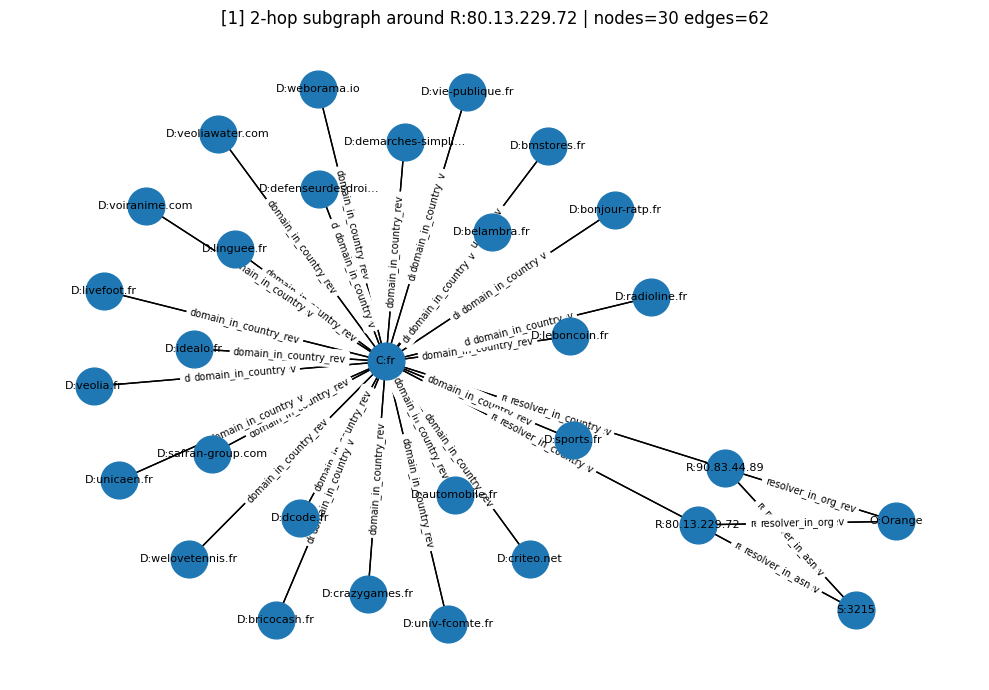

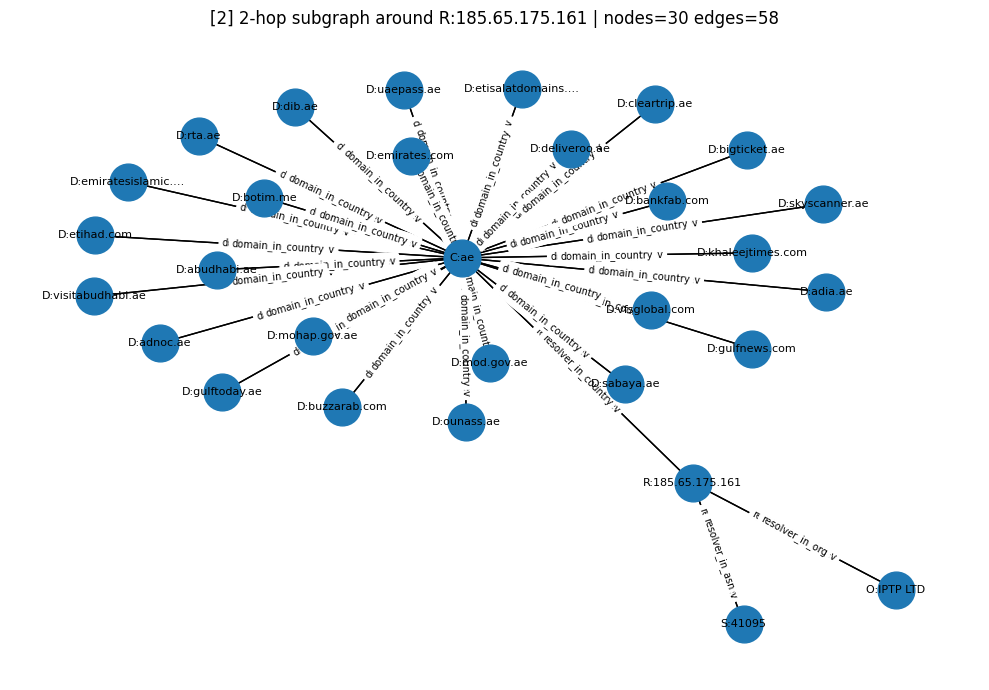

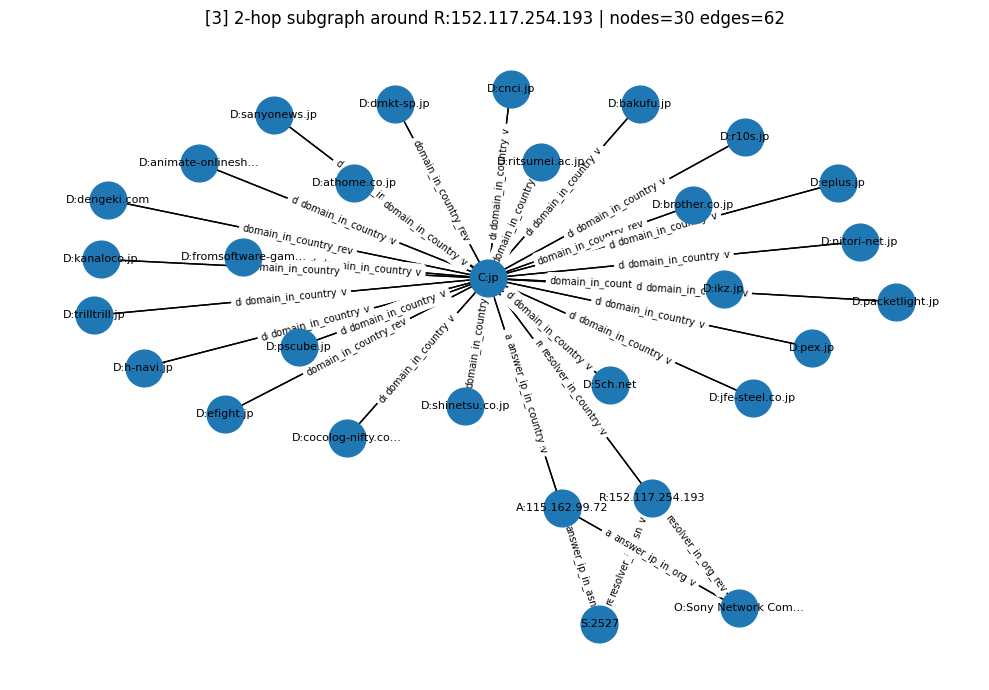

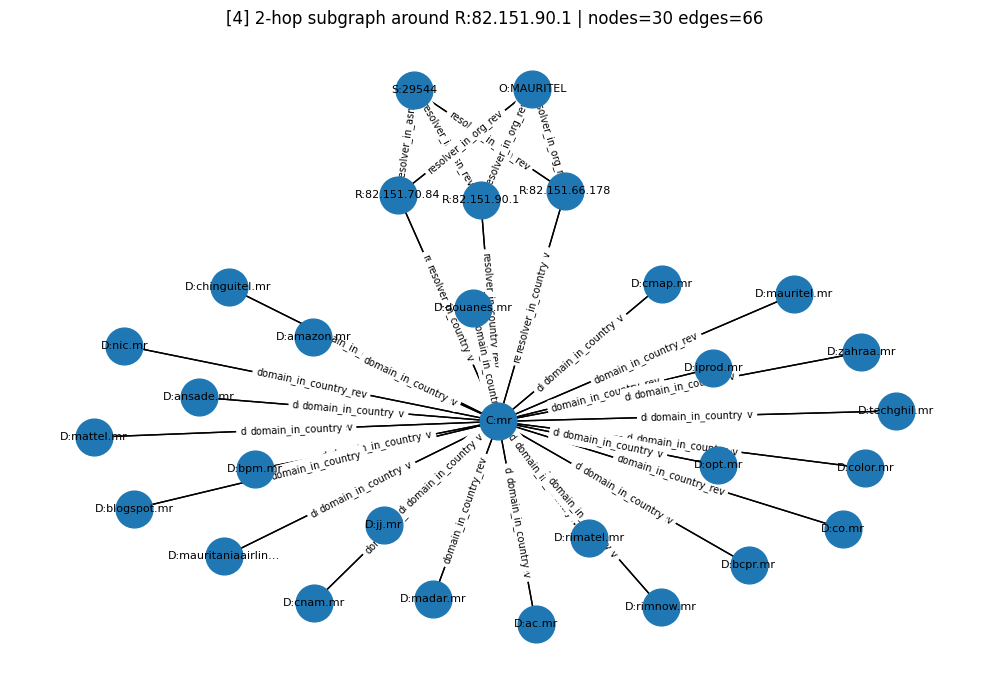

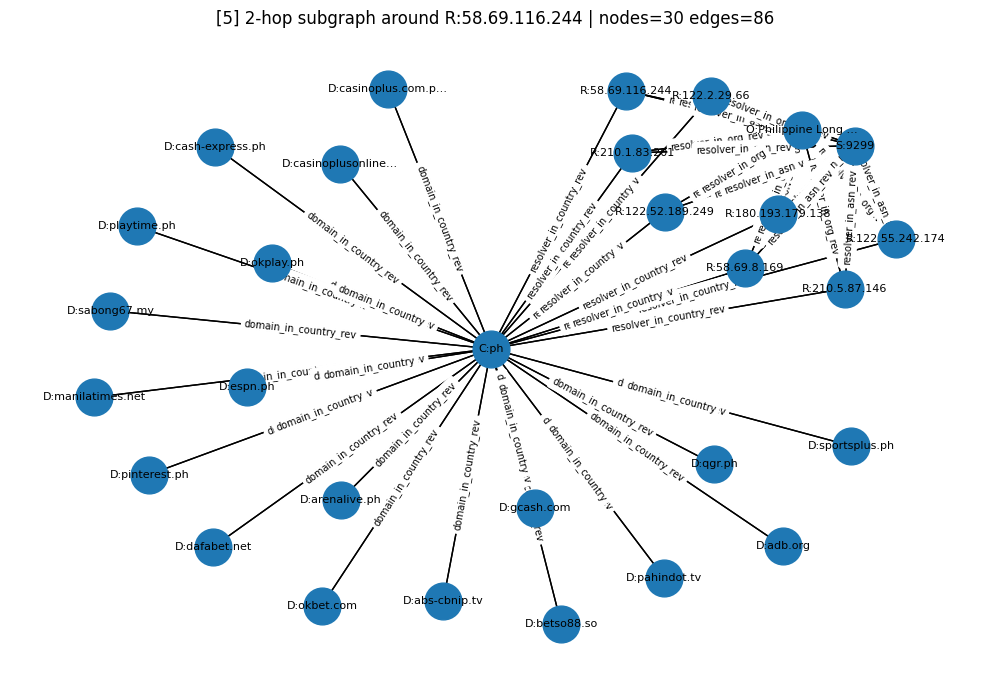

In [ ]:
import pickle
import random
import networkx as nx

with open("../outputs/entity_graph.gpickle", "rb") as f:
    G: nx.MultiDiGraph = pickle.load(f)

# get all A nodes
A_nodes = [n for n, d in G.nodes(data=True) if d.get("ntype") == "R"]
print(f"Total A nodes: {len(A_nodes)}")
if not A_nodes:
    raise SystemExit("No A nodes found.")

sample = random.sample(A_nodes, k=min(5, len(A_nodes)))


MAX_NODES = 30

try:
    import matplotlib.pyplot as plt
except ImportError:
    raise SystemExit("Please install matplotlib: pip install matplotlib")

for idx, a in enumerate(sample, 1):
    # 2-hop 关联子图：用 undirected=True 表示“关联”，不是严格方向可达
    # 2-hop associated subgraph: using undirected=True to indicate "association", not strict directional reachability
    sub = nx.ego_graph(G, a, radius=2, undirected=True)

    if sub.number_of_nodes() > MAX_NODES:
        keep = {a}
        frontier = [a]
        while frontier and len(keep) < MAX_NODES:
            u = frontier.pop(0)
            for v in sub.neighbors(u):
                if v not in keep:
                    keep.add(v)
                    frontier.append(v)
                if len(keep) >= MAX_NODES:
                    break
        sub = sub.subgraph(keep).copy()

    # MultiDiGraph 不好画边标签，这里压缩成 DiGraph（同一对点多条边只保留一个 rtype）
    # MultiDiGraph is not good for drawing edge labels, so we compress it into DiGraph (only one rtype is kept for multiple edges between the same pair of nodes)
    H = nx.DiGraph()
    for n in sub.nodes():
        H.add_node(n, **G.nodes[n])

    for u, v, data in sub.edges(data=True):
        r = data.get("rtype", "")
        # 如果已经有边，就不覆盖（也可改成拼接）
        # If there is already an edge, do not overwrite it (can also be changed to concatenate)
        if not H.has_edge(u, v):
            H.add_edge(u, v, rtype=r)

    # 布局 & 标签
    pos = nx.spring_layout(H, seed=42)

    def short_label(n: str) -> str:

        if len(n) <= 18:
            return n
        return n[:18] + "…"

    node_labels = {n: short_label(n) for n in H.nodes()}
    edge_labels = {(u, v): d.get("rtype", "") for u, v, d in H.edges(data=True)}

    plt.figure(figsize=(10, 7))
    nx.draw_networkx_nodes(H, pos, node_size=700)
    nx.draw_networkx_edges(H, pos, arrows=False, width=1.0)  
    nx.draw_networkx_labels(H, pos, labels=node_labels, font_size=8)
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=7)

    plt.title(f"[{idx}] 2-hop subgraph around {a} | nodes={H.number_of_nodes()} edges={H.number_of_edges()}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
